In [37]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline
from scipy.optimize import curve_fit

In [38]:
datadir='../XYscan data/610 150 GHz/'
Yscanfile, Xscanfile = glob(datadir + '*.txt')

0). We load the xpol,ypol data. Note that we take the Vr data and name it as Vx, because we observed some negative numbers on the Vx data whereas they are supposed to be small positive ones. The Vr's are all positive by definition. 

In [39]:
time_x,posno_x,xpos_x,ypos_x, Vx_x = np.loadtxt(Xscanfile, skiprows=9, delimiter=',', unpack=True, usecols=[0,1,2,3,6]) 
time_y,posno_y,xpos_y,ypos_y, Vx_y = np.loadtxt(Yscanfile, skiprows=9, delimiter=',', unpack=True, usecols=[0,1,2,3,6]) 

1). In order to make a the xy-mapping we first reshape the data into a box, where the height is the 10 amplitude data for each point on the square. We also take the average of the ten amplitudes, which flattens the box into a square that we want.
Note that the raster which does the xy-scan moves along a zigzag path, and we flipped the odd-index rows for the mapping.

In [40]:
t_x = time_x[10:-10].reshape([10,15,15],order='F')
X_x = xpos_x[10:-10].reshape([10,15,15],order='F')
Y_x = ypos_x[10:-10].reshape([10,15,15],order='F')
V_x = Vx_x[10:-10].reshape([10,15,15], order='F')
Vavg_x = np.average(V_x, axis=0)
tavg_x = np.average(t_x, axis=0)
Verr_x = np.std(V_x, axis=0)
Xarr_x = X_x[0,:,:]
Yarr_x = Y_x[0,:,:]

#for plotting
x = np.arange(-3.5,4.5,0.5)
y = np.arange(-3.5,4.5,0.5)
X_x_plt, Y_x_plt = np.meshgrid(x, y)

for k in range(1,X_x.shape[2],2):
    Yarr_x[:,k] = Yarr_x[::-1,k]
    Vavg_x[:,k] = Vavg_x[::-1,k]
    Verr_x[:,k] = Verr_x[::-1,k]
    tavg_x[:,k] = tavg_x[::-1,k]

In [41]:
t_y = time_y[10:-10].reshape([10,15,15],order='F')
X_y = xpos_y[10:-10].reshape([10,15,15],order='F')
Y_y = ypos_y[10:-10].reshape([10,15,15],order='F')
V_y = Vx_y[10:-10].reshape([10,15,15], order='F')
Vavg_y = np.average(V_y, axis=0)
tavg_y = np.average(t_y, axis=0)
Verr_y = np.std(V_y, axis=0)
Xarr_y = X_y[0,:,:]
Yarr_y = Y_y[0,:,:]

#for plotting
x = np.arange(-3.5,4.5,0.5)
y = np.arange(-3.5,4.5,0.5)
X_y_plt, Y_y_plt = np.meshgrid(x, y)

for k in range(1,X_y.shape[2],2):
    Yarr_y[:,k] = Yarr_y[::-1,k]
    Vavg_y[:,k] = Vavg_y[::-1,k]
    Verr_y[:,k] = Verr_y[::-1,k]
    tavg_y[:,k] = tavg_y[::-1,k]

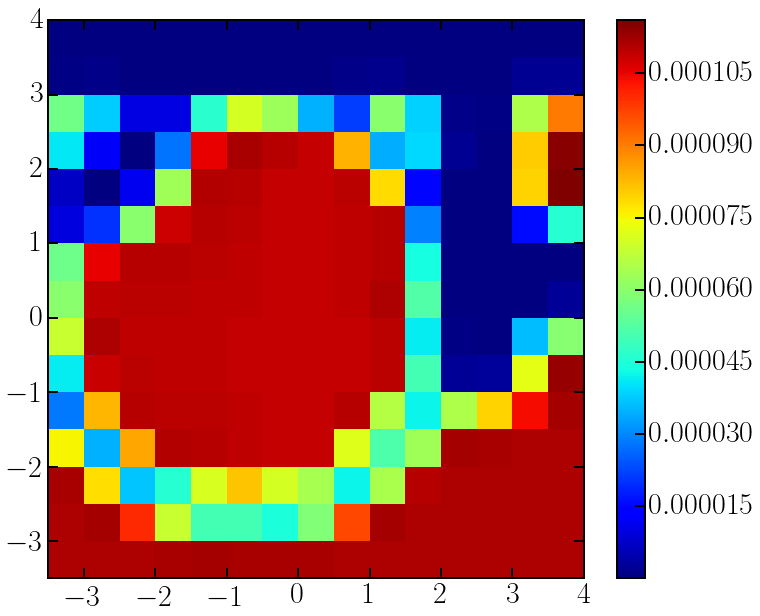

In [42]:
plt.figure(figsize=(12,10))
plt.pcolor(X_x_plt,Y_x_plt,Vavg_x,snap=True,cmap='jet');
plt.axis('tight')
plt.colorbar();

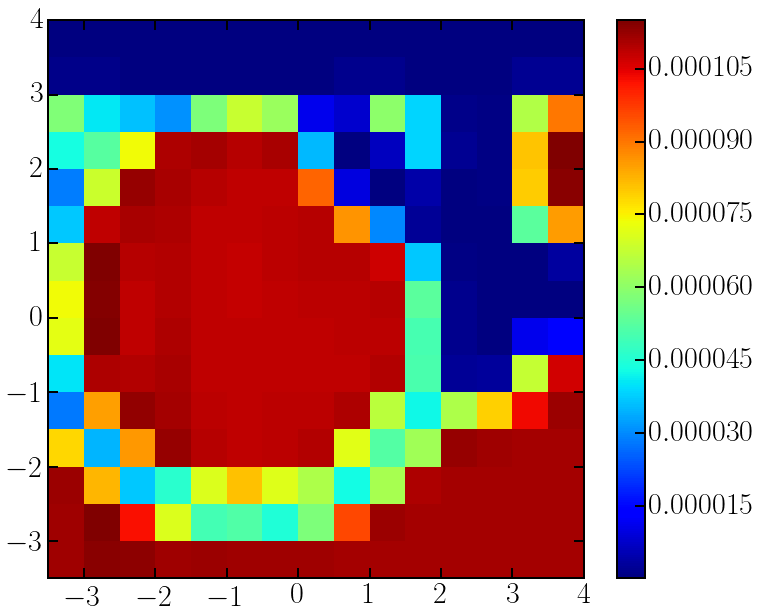

In [43]:
plt.figure(figsize=(12,10))
plt.pcolor(X_y_plt,Y_y_plt,Vavg_y,snap=True,cmap='jet');
plt.axis('tight')
plt.colorbar();

2). There can be a few 'spikes' in the data, which will make the average much higher than it should be. In order to detect this we calculate the standard deviation of the ten datas. The data points that have a higher rms than the average are likely to have a spike. After detecting those places we check the file and remomve the spike.

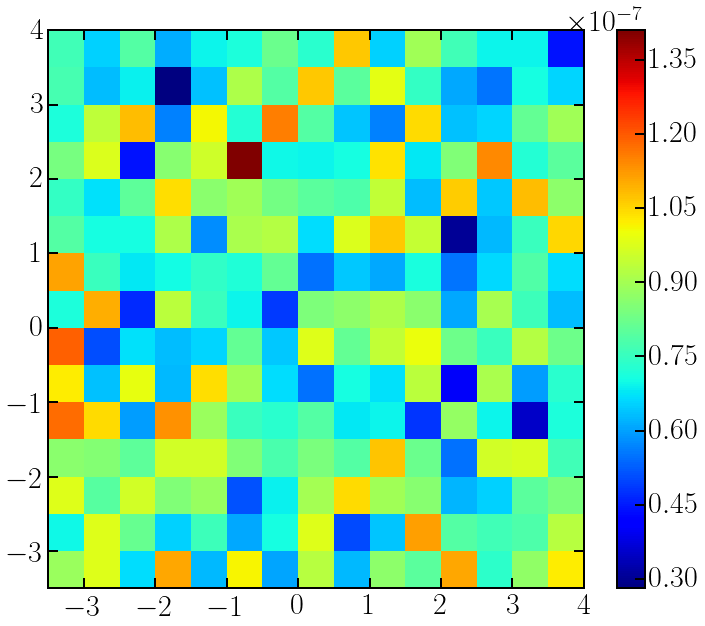

In [44]:
plt.figure(figsize=(12,10))
plt.pcolor(X_x_plt,Y_x_plt,Verr_x,snap=True,cmap='jet');
plt.axis('tight')
plt.colorbar();

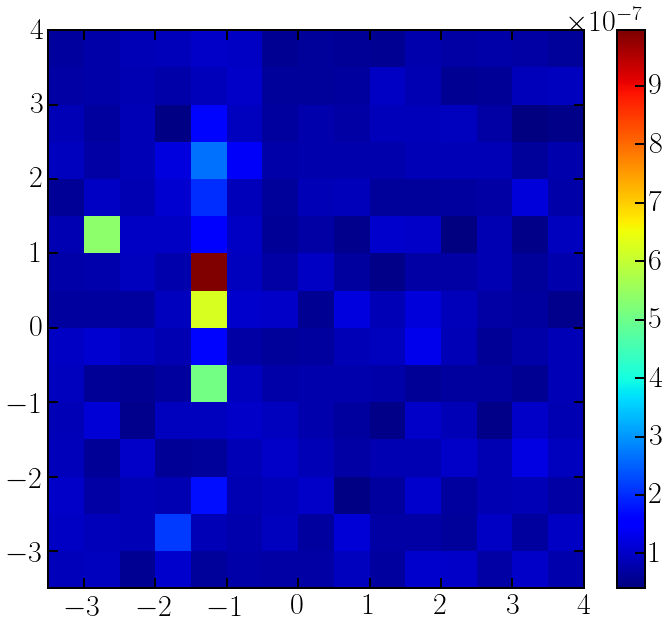

In [45]:
plt.figure(figsize=(12,10))
plt.pcolor(X_y_plt,Y_y_plt,Verr_y,snap=True,cmap='jet');
plt.axis('tight')
plt.colorbar();

In [46]:
#detecting the spikes for x
for i in range(len(Verr_x[:,0])):
    for j in range(len(Verr_x[:,0])): 
        if Verr_x[i,j] >  1.00 * Vavg_x[i,j]:
            print("For the xscan there's a spike in(",0.5*(j-7),",",0.5*(i-7),")");
        else:
            pass;

In [47]:
#detecting the spikes for y
for i in range(len(Verr_y[:,0])):
    for j in range(len(Verr_y[:,0])): 
        if Verr_y[i,j] >  1.00 * Vavg_y[i,j]:
            print("For the yscan there's a spike in(",0.5*(j-7),",",0.5*(i-7),")");
        else:
            pass;

3). Now we have to take into account the dependence of transmission over time. In order to do this we use the reference part (i.e. the bottom red row of the figure where the filter did not cover) and make a 5d polynomial fit fitted(time) of the time dependence vs the amplitude. The other datas taken at time t will be later normalized by dividing the amplitude by fitted(t).

[ -2.28552330e-19   6.33908516e-16  -6.43244403e-13   2.88678576e-10
  -5.46794377e-08   1.14723611e-04]


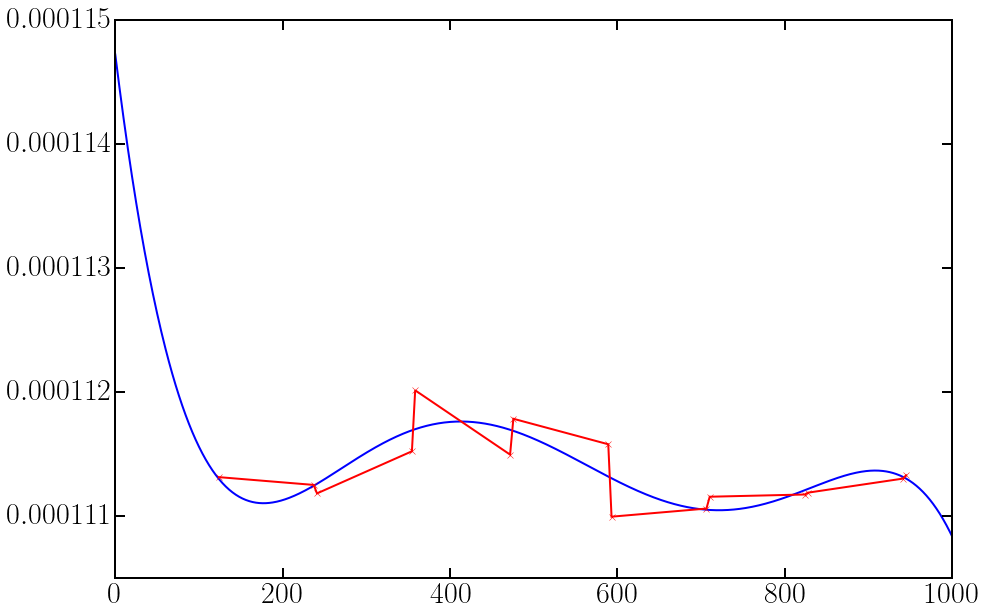

In [48]:
#take the reference part from the average calculated before
tavg_ref_x=tavg_x[0,:]
Vavg_ref_x=Vavg_x[0,:]

#fit with 5d polynomial
fit_coeff_x=np.polyfit(tavg_ref_x,Vavg_ref_x,5)
print(fit_coeff_x) 
fitted_x=np.poly1d(fit_coeff_x) # fitted as fit_coeff[0]*x**5+fit_coeff[1]*x**4+...+fit_coeff[5]

#plot
t1 = np.arange(0., 1000, 1)
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(fitted_x(t1), 'b-', tavg_ref_x, Vavg_ref_x, 'rx-');

[  5.32982489e-19  -1.52320221e-15   1.63391584e-12  -8.03156097e-10
   1.71837110e-07   1.00397876e-04]


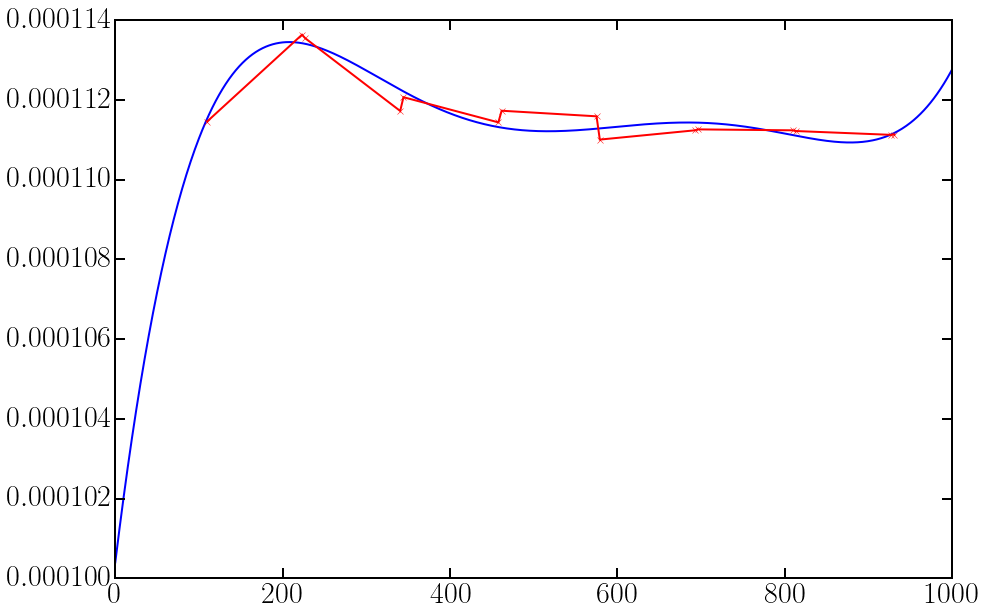

In [49]:
#take the reference part from the average calculated before
tavg_ref_y=tavg_y[0,:]
Vavg_ref_y=Vavg_y[0,:]
#fit with 5d polynomial
fit_coeff_y=np.polyfit(tavg_ref_y,Vavg_ref_y,5)
print(fit_coeff_y) 
fitted_y=np.poly1d(fit_coeff_y) # fitted as fit_coeff[0]*x**5+fit_coeff[1]*x**4+...+fit_coeff[5]

#plot
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(fitted_y(t1), 'b-', tavg_ref_y, Vavg_ref_y, 'rx-');

4). As mentioned before we normalize all the data by the fitted time-evolution polynomial, and plot the normalized amplitude. As we will check this will make the reference part (i.e. the first row) almost equal to one.

In [50]:
Vavg_normalized_x=Vavg_x/fitted_x(tavg_x)
print(Vavg_normalized_x[0,:]) #check the first row

[ 1.00012576  1.00005916  0.99930436  0.99848461  1.00280537  0.99820705
  1.00087275  1.00234213  0.99721832  1.00008574  1.00096189  0.99969294
  0.9997338   0.99986971  1.00023642]


In [51]:
Vavg_normalized_y=Vavg_y/fitted_y(tavg_y)
print(Vavg_normalized_y[0,:]) #check the first row

[ 0.99937809  1.00188073  1.00122969  0.99522878  0.99870461  1.00106196
  1.00381297  1.00279422  0.99748031  0.99825352  0.99848413  1.00108041
  1.0010612   0.99992071  0.99962937]


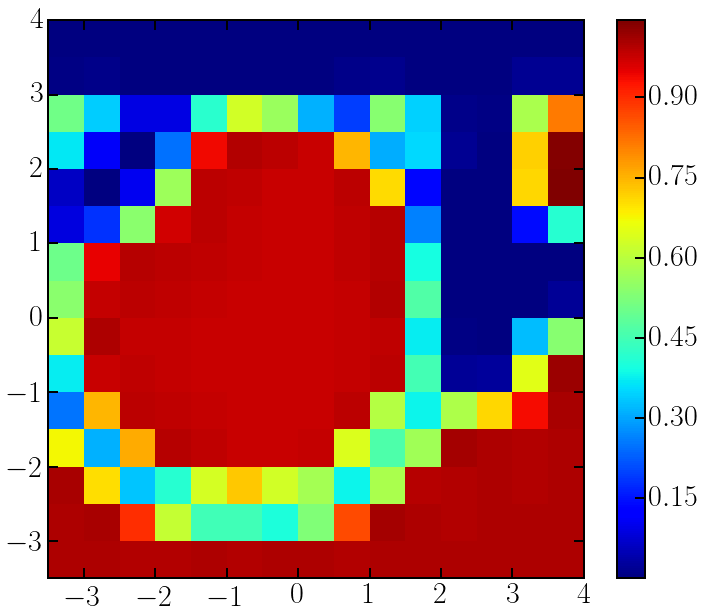

In [52]:
plt.figure(figsize=(12,10))
plt.pcolor(X_x_plt,Y_x_plt,Vavg_normalized_x,snap=True,cmap='jet');
plt.axis('tight')
plt.colorbar();

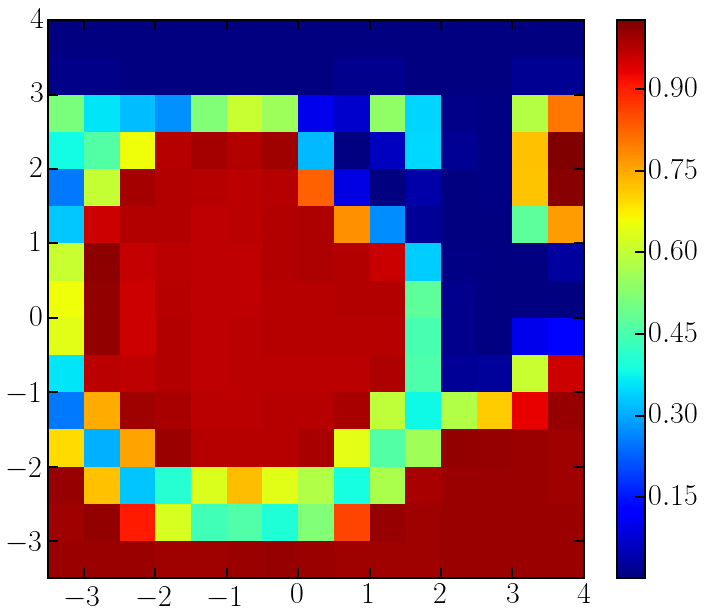

In [53]:
plt.figure(figsize=(12,10))
plt.pcolor(X_y_plt,Y_y_plt,Vavg_normalized_y,snap=True,cmap='jet');
plt.axis('tight')
plt.colorbar();